### Development notebook for smoothed seismicity
- Just smooth seismicity over a given kernel
- ... in particular, a nETAS (not-ETAS) PL function
- Experiment with different indexing strategies
  - Consider simple numpy indexing syntax, X[x>x1 and x<x2 and y>y1 and y<y2], etc.
  - Revisit rtree, etc.
- *Like* ETAS with $p=0$, but simpler, and more explicit; $sum(elements) = N_{eq}$


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
#from sklearn.neighbors import NearestNeighbors
import sklearn
import sklearn.neighbors
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
import global_etas_auto as ggep
from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

In [91]:
# get a catalog... for now, use the gep fancy ETAS catalogs... (note there is an _mpp version...)
lats = [31., 41.]
lons=[-120., -110.]
mc=2.5
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
cat_len=30
t1 = to_dt-dtm.timedelta(days=cat_len)
#
class Seismicity_Smoother(object):
    def __init__(self, lats, lons, cat=None, mc=2., date_range=[t1, to_dt], d_lat=.1, d_lon=.1,
                 map_lats=None, map_lons=None, etas_range_factor=25.):
        if date_range is None:
            date_range = [None, None]
        if date_range[1] is None:
            date_range[1] = dtm.datetime.now(pytz.timezone('UTC'))
        if date_range[0] is None:
            date_range[0] = date_range[1]-dt-dtm.timedelta(days=30)
        #
        lats = numpy.sort(lats)
        lons = numpy.sort(lons)
        #
        delta_lat = -numpy.subtract(*lats)
        delta_lon = -numpy.subtract(*lons)
        #print('*** ', delta_lat, delta_lon)
        #
        if map_lats is None:
            map_lats = [None, None]
        if map_lats[0] is None: map_lats[0] = lats[0] - 0.0*delta_lat
        if map_lats[1] is None: map_lats[1] = lats[1] + 0.10*delta_lat
        #
        if map_lons is None:
            map_lons = [None, None]
        if map_lons[0] is None: map_lons[0] = lons[0] - 0.0*delta_lon
        if map_lons[1] is None: map_lons[1] = lons[1] + 0.0*delta_lon 
        #
            
        if cat is None:
            cat = gep.make_ETAS_catalog(lats=lats, lons=lons, mc=mc, date_range=date_range)
        ## TODO: handle case of a simple catalog; run through make_ETAS_catalog() to get formatted catalog.
        #    test this to see if we need to pass parameters.
        print('*** ', cat.dtype.names)
        if not hasattr(cat, 'dtype') or not 'r_0' in cat.dtype.names:
            cat = gep.make_ETAS_catalog(incat=cat)
        #
        print('*** **', cat.dtype.names)
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
        self.XYZ = self.calc_seismicity_field()
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
    #
    def calc_seismicity_field(self):
        # TODO: pass lat, lon, etc. prams to facilitate MPP.
        # ... and let's try to MPP this within the function, quasi-recursively.
        min_lon = self.map_lons[0]
        max_lon = self.map_lons[1]
        min_lat = self.map_lats[0]
        max_lat = self.map_lats[1]
        d_lon = self.d_lon
        d_lat = self.d_lat
        XYZ = numpy.array([[x,y,0.] for y,x in itertools.product(numpy.arange(min_lat, max_lat+d_lat, d_lat),
                                                                numpy.arange(min_lon, max_lon+d_lon, d_lon)
                                                                )])
        #
        cat = self.cat
        # work on indexing later (and note, we'll need to handle global-warap-around). for now, just loop-loop:
        #q = cat['q']
        #r_0 = cat['r_0]']
        #chi_norm = q*(q-1.0)*(r_0**(q-1.0))
        ##
        #del q,r_0
        #
        for  (k, (x,y,z)), rw_eq in itertools.product(enumerate(XYZ), cat):
            #print('*** ', k, x,y,z, rw_eq, '** **', rw_eq['chi_norm'])
            XYZ[k][2] += (1./(math.pi*2.*rw_eq['chi_norm']))*(rw_eq['r_0'] + geopy.distance.great_circle((y,x),
                                                                    (rw_eq['lat'], rw_eq['lon'])).km)**(-1.-rw_eq['q'])
        
        #
        return numpy.core.records.fromarrays(zip(*XYZ), dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8')])
        
#
SSm = Seismicity_Smoother(lats=lats, lons=lons, mc=mc, date_range=[t1, to_dt])
#

NOTE: loading from comcat.
***  ('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'chi_norm', 'e_vals', 'e_vecs', 'N_eig_cat')
*** ** ('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'chi_norm', 'e_vals', 'e_vecs', 'N_eig_cat')


***  101 112 11312 11312
total:  15.619486018690704 45


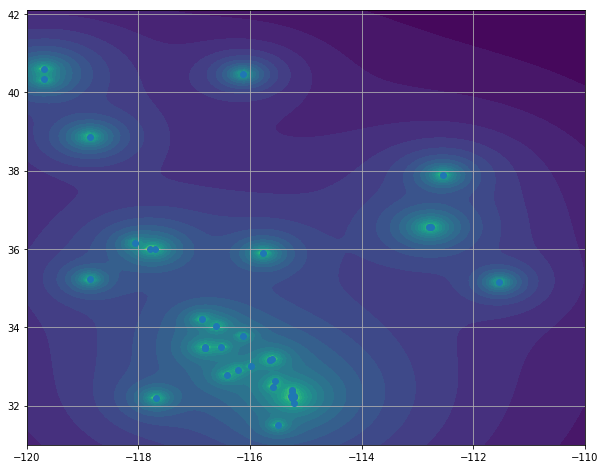

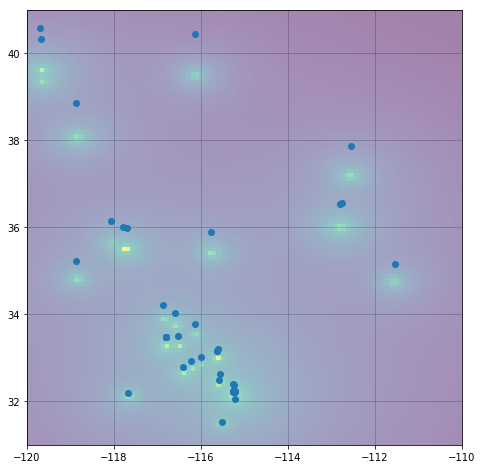

In [92]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()

ax.contourf(SSm.XYZ['x'].reshape(n_Y, n_X), SSm.XYZ['y'].reshape(n_Y, n_X),
            numpy.log(SSm.XYZ['z']).reshape(n_Y, n_X), 25)
ax.plot(SSm.cat['lon'], SSm.cat['lat'], ls='', marker='o', zorder=11)

fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
n_X = len(numpy.unique(SSm.XYZ['x']))
n_Y = len(numpy.unique(SSm.XYZ['y']))
# n_X = len(set(SSm.cat['lon']))
# n_Y = len(set(SSm.cat['lat']))
#ax.contourf(X = numpy.reshape(SSm.XYZ['x'], (n_Y, n_X)) , Y=numpy.reshape(SSm.XYZ['y'], (n_Y, n_X)),
print('*** ', n_X, n_Y, n_X*n_Y, len(SSm.XYZ))
ax.imshow(numpy.reshape(numpy.log(SSm.XYZ['z']), (n_Y, n_X)), extent= numpy.append(SSm.lons, SSm.lats) ,
          origin='lower', alpha=.5, zorder=2)

ax.plot(SSm.cat['lon'], SSm.cat['lat'], ls='', marker='o', zorder=11)
#
print('total: ', numpy.sum(SSm.XYZ['z']), len(SSm.cat))


In [93]:
print(len(SSm.XYZ))
print(numpy.subtract(*SSm.lons))

11312
-10.0


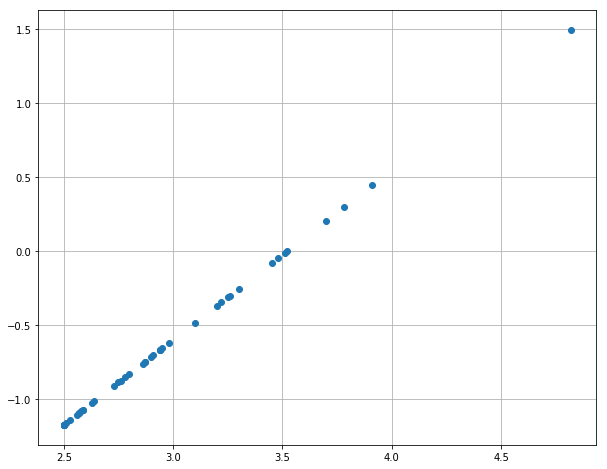

In [94]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
#
ax.plot(SSm.cat['mag'], numpy.log(SSm.cat['L_r']), ls='', marker='o')
#print(SSm.cat['L_r'][0:5])

In [95]:
print(SSm.XYZ[0:10])
print(len(set(SSm.XYZ['x'])), len(set(SSm.XYZ['y'])))

[(-120. , 31., 9.80271380e-06) (-119.9, 31., 1.02787241e-05)
 (-119.8, 31., 1.07882140e-05) (-119.7, 31., 1.13341208e-05)
 (-119.6, 31., 1.19196254e-05) (-119.5, 31., 1.25481474e-05)
 (-119.4, 31., 1.32233273e-05) (-119.3, 31., 1.39489868e-05)
 (-119.2, 31., 1.47290628e-05) (-119.1, 31., 1.55675033e-05)]
101 112


In [96]:
print(SSm.cat['chi_norm'])

[0.09201901 0.10802404 0.1928884  0.30823187 0.13322687 0.09201901
 0.14524187 0.21821145 0.16634908 0.23209365 0.1222058  0.09548804
 0.15834043 0.40432881 0.1603057  0.44626397 0.10031769 0.246859
 0.09316112 0.10936479 0.29703396 0.15834043 0.10282337 0.15834043
 0.15071735 1.60966197 0.2236618  0.1015628  0.12681285 0.14346127
 0.31985192 0.23497432 0.32382182 0.09908785 0.10282337 0.1299803
 0.09201901 0.09201901 0.09201901 0.14524187 0.52388345 0.10031769
 0.09201901 0.15258801 0.12525818]
